***

# BPR
- 관측된 평점과 관측되지 않은 평점간의 선호도 대소관계를 이용하여 선호도 순위를 예측하는 기법

### - Reference: [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf)

### - Prediction:
사용자 u가 아이템 i를 j보다 선호할 예측 확률 $P(i>_uj|\Theta)$을 아래와 같이 정의
<center> $P(i>_uj|\Theta) = \sigma(\hat{x_{uij}}(\Theta))$ </center>

|expression|mean|
|:---:|:---:|
|$\sigma(x)$|$$(1+e^{-x})^{-1}$$|
| $ \hat{x_{uij}}(\Theta)$|$$\hat{x_{ui}}(\Theta)-\hat{x_{uj}}(\Theta)$$|
| $ \hat{x_{ui}}(\Theta)$|$\Theta$가 주어졌을 때 사용자 $u$가 아이템 $i$를 선호하는 정도의 예측값|

### - Optimization:
사용자 u의 평점이 관측된 아이템 i와 관측되지 않은 아이템 j에 대하여, 아래와 같은 목적함수를 최대화하는 maxima를 찾음으로써 파라미터를 추정함
<center>$max_{(u,i,j)\in D_S} ln\sigma(\hat{x_{uij}})-\lambda_\Theta||\Theta||^2$</center>
목적함수는 사전확률 $P(\Theta)$와 우도확률 $P(\Theta|>_u)$ 을 이용하여 사후확률$P(>_u|\Theta)$ 을 추정한다는 베이즈정리로 부터 유도됨

|expression|mean|
|:---:|:---:|
|$D_S$|사용자 $u$와 평점이 관측된 아이템 $i$, 관측되지 않은 아이템 $j$의 집합<br />관측된 하나의$i$에 대하여 k개의 $j$를 임의추출하여 $(u, i, j)$을 만듬, $i$는 복원추출될 수 있음|
| $\Theta$|$x_{ui}$에 대한 분해 행렬 요소, $P_{n*k}, Q_{m*k}$로 분해할 수 있음($n$:사용자 수, $m$:아이템 수)|
|$P(\Theta)$ ~ $N(0, \sum_\Theta)$|사전확률은 정규분포를 따른다고 가정|
|$\lambda_\Theta$|$P, Q$에 대한 규제항 파라미터를 대각원소로 같는 공분산 |

### - Evaluation:
관측된 testset의 $x_{ui}$가  관측되지 않은 $x_{uj}$보다 더 큰 비율이 어느정도 되는지 측정함

</br>

<center>$AUC = |U|^{-1}\sum_{u}|E(u)|^{-1}\sum_{(i,j)\in E(u)} \delta(p_uq_i^T > p_uq_j^T)$</center>

|split|measure|
|:---:|:---:|
|leave-one-out|AUC|

***

## 0) Import library

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.PairwiseGenerator import PairwiseGenerator
from Models.BPR import BPR

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Data processing

### load data

In [2]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### convert id to index

In [3]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
...,...,...,...
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0


### convert explicit feedback to implicit feedback

In [4]:
ratings['rating'] = 1
ratings

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
100831,609,3120,1
100832,609,2035,1
100833,609,3121,1
100834,609,1392,1


### split data

In [5]:
leave_k = 1
seed = 1234

test = ratings.groupby('user_id').sample(leave_k, random_state=seed)
train_ = ratings.loc[ratings.index.isin(test.index)==False]
validation = train_.groupby('user_id').sample(leave_k, random_state=seed)
train = train_.loc[train_.index.isin(validation.index) == False]

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 99616, 610, 610


### set config & get dataset from generator

In [6]:
class DatasetConfig:
    num_negative = 5
    between_observed = False
    batch = 128
    
dataset_config = DatasetConfig()

In [7]:
dataset = PairwiseGenerator(train_data=train,
                            n_user=num_user,
                            n_item=num_item,
                            config=dataset_config)

### see example data for a batch

In [14]:
train_loader = DataLoader(dataset, batch_size=2)
data1, data2, data3 = next(iter(train_loader))

(1) [user id X batch_size]

In [15]:
data1

tensor([0, 0])

(2) [item id_pos X batch_size]

In [16]:
data2

tensor([0, 0])

(3) [item id_neg X batch_size]

In [17]:
data3

tensor([2410, 2803])

note. item_id_pos : positive item, item_id_neg : negative item

***

## 2) Modeling

### set config & get model

In [9]:
class OptimizerConfig:
    method = 'SGD'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 30
    print_step = 5

class BPRConfig:
    evaluation = 'AUC'
    dim_latent = 16

optimizer_config = OptimizerConfig()
bpr_config = BPRConfig()
model_config = ModelConfig()

In [10]:
inputs = {"n_user":num_user,
          "n_item":num_item}

model = BPR(inputs, model_config, optimizer_config, bpr_config)

[BaseModel] method = SGD
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [11]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[BPR]============================================== Train ===============================================
[BPR]               (train: BPRloss)    (validation: AUC)   
          (epoch 5) 39.5342             0.8958              
         (epoch 10) 27.3984             0.9112              
         (epoch 15) 20.7468             0.9225              
         (epoch 20) 17.3588             0.9279              
         (epoch 25) 15.3706             0.9309              
         (epoch 30) 14.1355             0.9327              


***

## 3) Evaluation

### evaluate testset

In [12]:
model.test(train_loader=train_loader, test_data=test)


[BPR]============================================= Evaluate =============================================
[BPR] (test: AUC) = 0.9238


### see plot for loss and performance

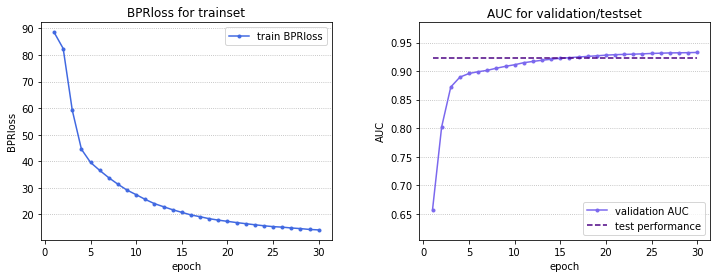

In [13]:
figure = model.draw_plot()
plt.show()